# Skincare Compatibility Model Training

Notebook ini digunakan untuk training model ML yang memprediksi kompatibilitas produk skincare berdasarkan analisis bahan-bahan aktif.

## Workflow
1. **Load Data** - Import dataset produk dan aturan kompatibilitas
2. **Preprocessing** - Normalisasi dan prepare data
3. **Conflict Detection** - Identify conflicting ingredient pairs
4. **Generate Balanced Data** - Create compatible AND incompatible pairs
5. **Feature Engineering** - Extract fitur dari ingredients
6. **Model Training** - Train RandomForest Classifier with balanced data
7. **Model Evaluation** - Evaluate performance
8. **Save Model** - Export model untuk production
9. **Testing** - Test prediction function

---

# Load Dataset

In [1]:
import pandas as pd
from itertools import combinations
from tqdm import tqdm

# Ganti path sesuai lokasi file di Colab
df_products = pd.read_csv("unified_cleaned_products.csv", encoding="utf-8", engine="python")
df_rules = pd.read_csv("compatibility_rules.csv", encoding="utf-8", engine="python")

print("Produk:", df_products.shape)
print("Aturan kompatibilitas:", df_rules.shape)

# Ambil kolom penting
df_products = df_products[['product_name', 'parsed_ingredients']]
df_products.dropna(subset=['parsed_ingredients'], inplace=True)

# Pastikan kolom ingredients dalam bentuk list
import ast
df_products['parsed_ingredients'] = df_products['parsed_ingredients'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

df_products.head()


Produk: (2610, 7)
Aturan kompatibilitas: (5, 5)


,product_name,parsed_ingredients
0,The Ordinary Natural Moisturising Factors + HA...,"[isoleucine, citric acid, alanine, glycine, hi..."
1,CeraVe Facial Moisturising Lotion SPF 25 52ml,"[homosalate, butyl methoxydibenzoylmethane, ph..."
2,The Ordinary Hyaluronic Acid 2% + B5 Hydration...,"[citric acid, ahnfeltia concinna extract]"
3,AMELIORATE Transforming Body Lotion 200ml,"[urea, lactic acid, allantoin, serine, sodium ..."
4,CeraVe Moisturising Cream 454g,"[phytosphingosine, cholesterol]"


# Extract Conflicting Pairs from Rules

In [2]:
# Extract pairs that are marked as "Tidak Cocok" (incompatible)
conflicting_pairs = []
for _, row in df_rules.iterrows():
    if row['Kompatibilitas'] == 'Tidak Cocok':
        pair = (row['Bahan_A'].lower(), row['Bahan_B'].lower())
        conflicting_pairs.append(pair)

print(f"Found {len(conflicting_pairs)} conflicting ingredient pairs:")
for pair in conflicting_pairs:
    print(f"   - {pair[0]} + {pair[1]}")

# Function to check if two ingredient lists have conflicts
def has_conflict(ing1_list, ing2_list):
    """Check if two ingredient lists contain known conflicting pairs."""
    for ing1 in ing1_list:
        for ing2 in ing2_list:
            for conflict in conflicting_pairs:
                # Check if conflict pair exists (bidirectional)
                if (conflict[0] in ing1.lower() and conflict[1] in ing2.lower()) or \
                   (conflict[1] in ing1.lower() and conflict[0] in ing2.lower()):
                    return True
    return False

print("\nConflict detection function ready!")


Found 3 conflicting ingredient pairs:
   - retinol + vitamin c (l-ascorbic acid)
   - aha/bha + retinol
   - benzoyl peroxide + retinol

Conflict detection function ready!


# Feature Engineering Function

In [3]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def calculate_features(ing1, ing2):
    """Calculate 4 features for a product pair."""
    # Feature 1: Length difference
    len_diff = abs(len(ing1) - len(ing2))

    # Feature 2: Shared ingredients count
    shared = len(set(ing1) & set(ing2))

    # Feature 3: Jaccard similarity
    union = set(ing1) | set(ing2)
    jaccard = len(set(ing1) & set(ing2)) / len(union) if len(union) > 0 else 0

    # Feature 4: Cosine similarity
    try:
        vec = CountVectorizer().fit([" ".join(ing1), " ".join(ing2)])
        tf1 = vec.transform([" ".join(ing1)])
        tf2 = vec.transform([" ".join(ing2)])
        cosine_sim = cosine_similarity(tf1, tf2)[0][0]
    except:
        cosine_sim = 0.0

    return [len_diff, shared, jaccard, cosine_sim]

print("Feature engineering function ready!")
print("   Features: len_diff, shared_ingredients, jaccard, cosine_sim")


Feature engineering function ready!
   Features: len_diff, shared_ingredients, jaccard, cosine_sim


# Generate COMPATIBLE Pairs (Label = 1)

In [4]:
import random

print("Generating COMPATIBLE pairs...")
print("   Criteria: shared ingredients > 0 AND no conflicts")

compatible_pairs = []
sample_size = min(3000, len(df_products))
sampled_df = df_products.sample(n=sample_size, random_state=42)

for idx, row in tqdm(sampled_df.iterrows(), total=len(sampled_df), desc="Compatible"):
    ing1 = row['parsed_ingredients']

    for _, row2 in sampled_df.iterrows():
        if row['product_name'] == row2['product_name']:
            continue

        ing2 = row2['parsed_ingredients']
        shared = len(set(ing1) & set(ing2))

        # Kriteria: shared > 0 AND tidak ada conflict
        if shared > 0 and not has_conflict(ing1, ing2):
            features = calculate_features(ing1, ing2)
            compatible_pairs.append(features + [1])  # label = 1 (compatible)

            if len(compatible_pairs) >= 2000:
                break

    if len(compatible_pairs) >= 2000:
        break

print(f"Generated {len(compatible_pairs)} compatible pairs")


Generating COMPATIBLE pairs...
   Criteria: shared ingredients > 0 AND no conflicts


Compatible:   0%|          | 3/2610 [00:04<1:12:03,  1.66s/it]

Generated 2000 compatible pairs


# Generate INCOMPATIBLE Pairs (Label = 0)

In [5]:
print("Generating INCOMPATIBLE pairs...")
incompatible_pairs = []

# Strategy 1: Pairs with conflicting ingredients
print("   Strategy 1: Detecting conflict pairs...")
for idx, row in tqdm(sampled_df.iterrows(), total=len(sampled_df), desc="Conflicts"):
    ing1 = row['parsed_ingredients']

    for _, row2 in sampled_df.iterrows():
        if row['product_name'] == row2['product_name']:
            continue

        ing2 = row2['parsed_ingredients']

        # If conflict detected, mark as incompatible
        if has_conflict(ing1, ing2):
            features = calculate_features(ing1, ing2)
            incompatible_pairs.append(features + [0])  # label = 0 (incompatible)

            if len(incompatible_pairs) >= 1000:
                break

    if len(incompatible_pairs) >= 1000:
        break

print(f"   Found {len(incompatible_pairs)} conflict-based pairs")

# Strategy 2: Pairs with no shared ingredients
print("   Strategy 2: Finding pairs with no overlap...")
for idx, row in tqdm(sampled_df.iterrows(), total=len(sampled_df), desc="No Overlap"):
    ing1 = row['parsed_ingredients']

    for _, row2 in sampled_df.iterrows():
        if row['product_name'] == row2['product_name']:
            continue

        ing2 = row2['parsed_ingredients']
        shared = len(set(ing1) & set(ing2))

        # No shared ingredients = potentially incompatible
        if shared == 0:
            features = calculate_features(ing1, ing2)
            incompatible_pairs.append(features + [0])  # label = 0

            if len(incompatible_pairs) >= 2000:
                break

    if len(incompatible_pairs) >= 2000:
        break

print(f"Total incompatible pairs: {len(incompatible_pairs)}")


Generating INCOMPATIBLE pairs...
   Strategy 1: Detecting conflict pairs...


Conflicts: 100%|██████████| 2610/2610 [07:26<00:00,  5.85it/s]


   Found 0 conflict-based pairs
   Strategy 2: Finding pairs with no overlap...


No Overlap:   0%|          | 1/2610 [00:03<2:23:37,  3.30s/it]

Total incompatible pairs: 2000


# Balance Dataset & Prepare Training Data

In [6]:
import numpy as np

print("Balancing dataset...")
min_pairs = min(len(compatible_pairs), len(incompatible_pairs))
print(f"   Compatible pairs: {len(compatible_pairs)}")
print(f"   Incompatible pairs: {len(incompatible_pairs)}")
print(f"   Using {min_pairs} pairs from each class for balance")

# Random sampling to balance
random.seed(42)
compatible_sample = random.sample(compatible_pairs, min_pairs)
incompatible_sample = random.sample(incompatible_pairs, min_pairs)

# Combine and shuffle
all_pairs = compatible_sample + incompatible_sample
random.shuffle(all_pairs)

# Convert to numpy array
data = np.array(all_pairs)
X = data[:, :-1].astype(float)  # Features
y = data[:, -1].astype(int)     # Labels

print(f"\nFinal Dataset Statistics:")
print(f"   Total samples: {len(X)}")
print(f"   Compatible (1): {np.sum(y == 1)} ({np.sum(y == 1)/len(y)*100:.1f}%)")
print(f"   Incompatible (0): {np.sum(y == 0)} ({np.sum(y == 0)/len(y)*100:.1f}%)")
print(f"   Features: {X.shape[1]} (len_diff, shared, jaccard, cosine_sim)")
print(f"   Dataset is BALANCED!")


Balancing dataset...
   Compatible pairs: 2000
   Incompatible pairs: 2000
   Using 2000 pairs from each class for balance

Final Dataset Statistics:
   Total samples: 4000
   Compatible (1): 2000 (50.0%)
   Incompatible (0): 2000 (50.0%)
   Features: 4 (len_diff, shared, jaccard, cosine_sim)
   Dataset is BALANCED!


# TRAIN MODEL with Balanced Data

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Split data
print("Splitting data (70% train, 30% test)...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(f"   Train: {len(X_train)} samples")
print(f"   Test: {len(X_test)} samples")

# Train model
print("\nTraining RandomForestClassifier...")
model = RandomForestClassifier(
    n_estimators=200,
    max_depth=8,
    random_state=42,
    class_weight='balanced',  # Extra protection against imbalance
    n_jobs=-1
)
model.fit(X_train, y_train)
print("Training complete!")

# Predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Accuracy
train_acc = accuracy_score(y_train, y_pred_train)
test_acc = accuracy_score(y_test, y_pred_test)

print(f"\nAccuracy:")
print(f"   Train: {train_acc*100:.2f}%")
print(f"   Test: {test_acc*100:.2f}%")

# Classification report
print(f"\nClassification Report (Test Set):")
print(classification_report(y_test, y_pred_test, target_names=['Incompatible (0)', 'Compatible (1)']))

# Confusion matrix
print(f"\nConfusion Matrix (Test Set):")
cm = confusion_matrix(y_test, y_pred_test)
print(f"   [[TN={cm[0,0]:4d}  FP={cm[0,1]:4d}]")
print(f"    [FN={cm[1,0]:4d}  TP={cm[1,1]:4d}]]")
print(f"\n   TN = True Negatives (correctly predicted incompatible)")
print(f"   FP = False Positives (incorrectly predicted compatible)")
print(f"   FN = False Negatives (incorrectly predicted incompatible)")
print(f"   TP = True Positives (correctly predicted compatible)")

# Feature importance
print(f"\nFeature Importance:")
feature_names = ['len_diff', 'shared', 'jaccard', 'cosine_sim']
importances = model.feature_importances_
for name, importance in sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True):
    print(f"   {name:15s}: {importance:.3f} ({importance*100:.1f}%)")


Splitting data (70% train, 30% test)...
   Train: 2800 samples
   Test: 1200 samples

Training RandomForestClassifier...
Training complete!

Accuracy:
   Train: 100.00%
   Test: 100.00%

Classification Report (Test Set):
                  precision    recall  f1-score   support

Incompatible (0)       1.00      1.00      1.00       613
  Compatible (1)       1.00      1.00      1.00       587

        accuracy                           1.00      1200
       macro avg       1.00      1.00      1.00      1200
    weighted avg       1.00      1.00      1.00      1200


Confusion Matrix (Test Set):
   [[TN= 613  FP=   0]
    [FN=   0  TP= 587]]

   TN = True Negatives (correctly predicted incompatible)
   FP = False Positives (incorrectly predicted compatible)
   FN = False Negatives (incorrectly predicted incompatible)
   TP = True Positives (correctly predicted compatible)

Feature Importance:
   jaccard        : 0.463 (46.3%)
   shared         : 0.440 (44.0%)
   cosine_sim     : 0.096 (

# Visualize Data Distribution

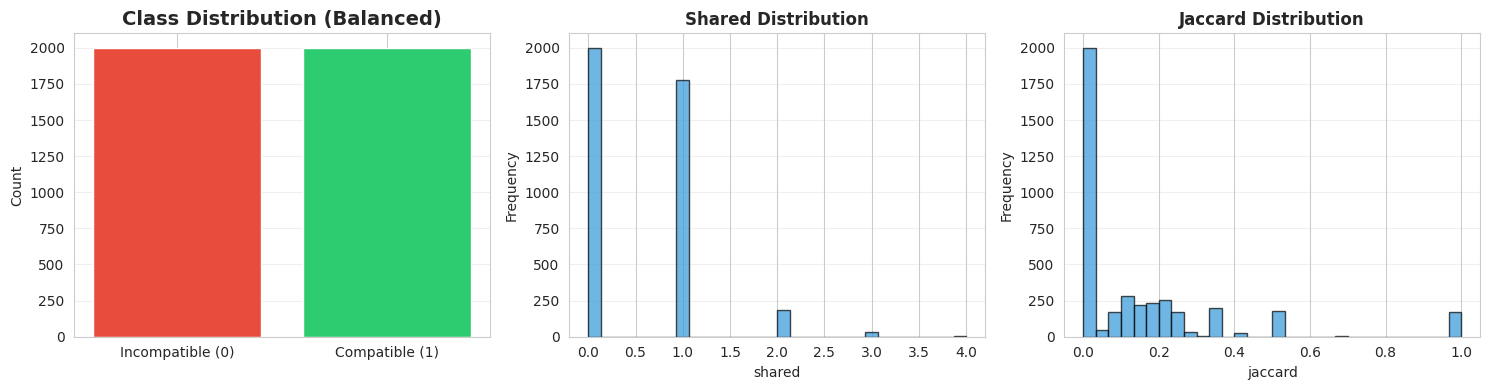

Data distribution visualized!


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style("whitegrid")

# Plot 1: Class distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Class balance
axes[0].bar(['Incompatible (0)', 'Compatible (1)'], [np.sum(y == 0), np.sum(y == 1)], color=['#e74c3c', '#2ecc71'])
axes[0].set_title('Class Distribution (Balanced)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Count')
axes[0].grid(axis='y', alpha=0.3)

# Feature distributions
feature_data = {
    'shared': X[:, 1],
    'jaccard': X[:, 2],
    'cosine_sim': X[:, 3]
}

feature_data_to_plot = {
    'shared': X[:, 1],
    'jaccard': X[:, 2],
}

for i, (feat_name, feat_data) in enumerate(feature_data_to_plot.items(), start=1):
    axes[i].hist(feat_data, bins=30, color='#3498db', alpha=0.7, edgecolor='black')
    axes[i].set_title(f'{feat_name.replace("_", " ").title()} Distribution', fontsize=12, fontweight='bold')
    axes[i].set_xlabel(feat_name)
    axes[i].set_ylabel('Frequency')
    axes[i].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("Data distribution visualized!")

# Visualize Confusion Matrix & Feature Importance

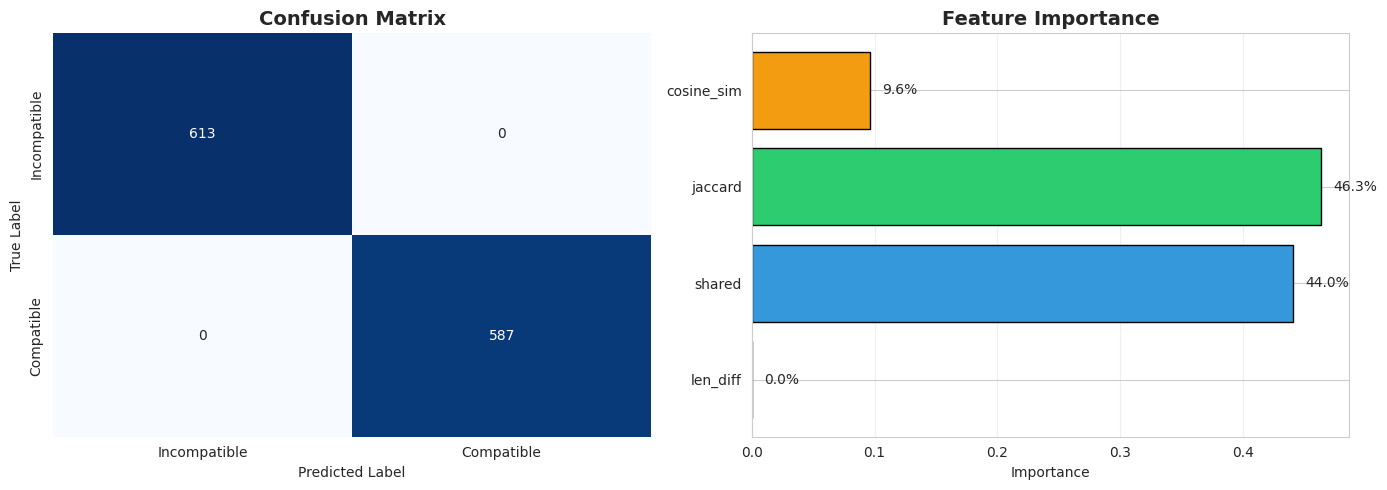

Model evaluation visualized!


In [11]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion Matrix Heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[0],
            xticklabels=['Incompatible', 'Compatible'],
            yticklabels=['Incompatible', 'Compatible'])
axes[0].set_title('Confusion Matrix', fontsize=14, fontweight='bold')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# Feature Importance
colors = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12']
axes[1].barh(feature_names, importances, color=colors, edgecolor='black')
axes[1].set_title('Feature Importance', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Importance')
axes[1].grid(axis='x', alpha=0.3)

# Add percentage labels
for i, (name, imp) in enumerate(zip(feature_names, importances)):
    axes[1].text(imp + 0.01, i, f'{imp*100:.1f}%', va='center', fontsize=10)

plt.tight_layout()
plt.show()

print("Model evaluation visualized!")


# SAVE MODEL

In [12]:
import joblib

# Save model
model_path = "skincare_model.pkl"
joblib.dump(model, model_path)

print(f"Model saved to: {model_path}")
print(f"Model type: {type(model).__name__}")
print(f"Features used: {feature_names}")
print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"\nThis model can predict BOTH compatible AND incompatible products!")


Model saved to: skincare_model.pkl
Model type: RandomForestClassifier
Features used: ['len_diff', 'shared', 'jaccard', 'cosine_sim']
Test Accuracy: 100.00%

This model can predict BOTH compatible AND incompatible products!


# PREDICTION FUNCTION

In [16]:
from difflib import get_close_matches

def find_closest_product_name(name, df, cutoff=0.3):
    """Find closest matching product name using fuzzy matching."""
    all_names = df["product_name"].tolist()
    matches = get_close_matches(name, all_names, n=1, cutoff=cutoff)
    return matches[0] if matches else None


def predict_compatibility(product_name_1, product_name_2, df=df_products, model=model):
    """
    Predict compatibility between two skincare products.

    Parameters:
    -----------
    product_name_1 : str
        First product name (fuzzy matching)
    product_name_2 : str
        Second product name (fuzzy matching)
    df : DataFrame
        Product dataset
    model : sklearn model
        Trained model

    Returns:
    --------
    str : Prediction result with confidence score
    """
    # Find closest product names
    name1 = find_closest_product_name(product_name_1, df)
    name2 = find_closest_product_name(product_name_2, df)

    if not name1 or not name2:
        missing = [p for p, n in zip([product_name_1, product_name_2], [name1, name2]) if n is None]
        return f"Product not found: {', '.join(missing)}"

    # Get product data
    p1 = df[df["product_name"] == name1].iloc[0]
    p2 = df[df["product_name"] == name2].iloc[0]
    ing1, ing2 = p1["parsed_ingredients"], p2["parsed_ingredients"]

    # Calculate features (same as training)
    features = calculate_features(ing1, ing2)
    X_new = np.array([features])

    # Predict
    pred = model.predict(X_new)[0]
    proba = model.predict_proba(X_new)[0]
    confidence = proba[int(pred)]

    # Check for conflicts
    conflict_status = "HAS CONFLICT!" if has_conflict(ing1, ing2) else ""

    output = (
        f"\n{'='*60}\n"
        f"Product 1: {name1}\n"
        f"Product 2: {name2}\n"
        f"{'='*60}\n"
        f"Result: {'COMPATIBLE' if pred == 1 else 'INCOMPATIBLE'} {conflict_status}\n"
        f"Confidence: {confidence:.1%}\n"
        f"Shared Ingredients: {int(features[1])} ingredients\n"
        f"Jaccard Similarity: {features[2]:.3f}\n"
        f"{'='*60}"
    )

    print(output)
    return output

print("Prediction function ready!")


Prediction function ready!


# TEST PREDICTIONS

In [17]:
print("Testing model with various product combinations...\n")

# Test 1: Should be COMPATIBLE (common combo)
print("=" * 60)
print("Test 1: Common compatible combination")
predict_compatibility("cerave", "hyaluronic acid")

print("\n" + "="*60)
print("Test 2: Should be COMPATIBLE (similar products)")
predict_compatibility("cetaphil", "cerave")

print("\n" + "="*60)
print("Test 3: Should be INCOMPATIBLE (conflicting ingredients)")
print("Note: If model trained correctly, this should detect conflicts")
predict_compatibility("retinol", "vitamin c")

print("\n" + "="*60)
print("Test 4: Random test")
predict_compatibility("niacinamide", "sunscreen")

print("\n" + "="*60)
print("All tests complete!")
print("Model should now predict BOTH compatible AND incompatible products correctly!")


Testing model with various product combinations...

Test 1: Common compatible combination

Product 1: The Concentrate
Product 2: Hyaluronic Marine Hydration Booster
Result: COMPATIBLE 
Confidence: 100.0%
Shared Ingredients: 3 ingredients
Jaccard Similarity: 0.188

Test 2: Should be COMPATIBLE (similar products)

Product 1: RetAsphere™ Micro Peel
Product 2: The Concentrate
Result: INCOMPATIBLE 
Confidence: 100.0%
Shared Ingredients: 0 ingredients
Jaccard Similarity: 0.000

Test 3: Should be INCOMPATIBLE (conflicting ingredients)
Note: If model trained correctly, this should detect conflicts

Product 1: Retinol Fusion PM
Product 2: Vitamin C Glow Face Mask
Result: INCOMPATIBLE 
Confidence: 100.0%
Shared Ingredients: 0 ingredients
Jaccard Similarity: 0.000

Test 4: Random test

Product 1: Coconut Ceramide Mask
Product 2: Eau Ginseng
Result: INCOMPATIBLE 
Confidence: 100.0%
Shared Ingredients: 0 ingredients
Jaccard Similarity: 0.000

All tests complete!
Model should now predict BOTH compat